In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random, os
import numpy as np
import torch
import importlib
import deeptrack as dt
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE.single import objVAE_single, bg_single, utils_single


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

2024-02-04 15:48:29.007488: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 15:48:30.550815: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

In [2]:
def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()

    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            pres_loss
        ) = model(x)
        alpha = z_pres.detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[alpha]
        edge_color = plt.cm.get_cmap('spring')(z_pres[alpha].detach().cpu().numpy())

    else:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            pres_loss
        ) = model(x)
        xy = xy.detach().cpu().numpy()[:]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 3)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], s=10, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")

    plt.subplot(2, 2, 1)
    plt.imshow(
        background[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("background")

    plt.subplot(2, 2, 2)
    plt.imshow(
        x_hat[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("forground")

    plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

(110, 130, 174)
torch.Size([110, 1, 128, 128])


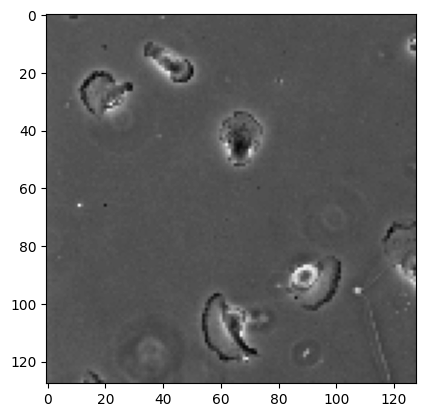

In [6]:
import tifffile
from glob import glob
import cv2

x_crop = 512
y_crop = 512

paths = r'/data/mp_mpa/PhC-C2DH-U373/*.tif'
paths = sorted(glob(paths))

images = [
    tifffile.imread(path) for path in paths
]
 
images = np.array(images)[:110, ::4, ::4]

print(images.shape)

#images = np.concatenate(images_array, axis=0)
images = images[:,  :128, :128]

images = np.abs((images-np.min(images))/(np.max(images)-np.min(images)))

training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(0, 1, 2), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=1)
print(training_images.shape)
plt.imshow(np.squeeze(training_images[0,:,:]), cmap='gray')

In [7]:
train, test = torch.utils.data.random_split(training_images, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [8]:
import IPython.display as ipd

# Callbacks
max_steps = 10000
beta_annealing_end = max_steps
lr_annealing_end = max_steps
kl_annealing_end = 2400
presence_annealing_end = 2500
unfreeze = 0

def beta_annealing(step):
    logs = np.logspace(-0, -0, beta_annealing_end) # 8.3 - 7
    if step < unfreeze:
        return 0
    if step < beta_annealing_end:
        return 0
    else:
        return 0
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < kl_annealing_end*0.5:
        return 0
    if step < kl_annealing_end:
        return 0
    else:
        return 0

def presence_annealing(step):
    lins = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return 0#lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 10:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [19]:
importlib.reload(objVAE_single)
importlib.reload(bg_single)
torch.autograd.set_detect_anomaly(True)

load_model = ""

#load_model = "../state_dicts/model-5-20000-presW-glim32-an.pth"
#load_model = "../state_dicts/model-microtubuler-256px-bad.pth"


use_attention = False
num_entities = 15
softmax_tmp = 1
latent_dim = 5
beta = 1e-4
number_of_heads = 1
object_radius = 16
combine_method = "max"
topk_select_method = 'max'
decoder="linnear"
decoder_feature_size=56 #56
encoder_num_layers=3
decoder_num_layers=8

single_decoder = True
attention_mechanism='dot-product'

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 30,
    'decoder_norm': 'batch',
    'decoder_depth': 6,
    'encoder_activation': 'relu',
    'encoder_channels': 16,
    'encoder_norm': 'instance',
    'encoder_depth': 6,
    'hidden_dim': 4,
    'position_dim': 128
}

background_model = bg_single.objBG(in_channels=1,image_size=128, **bg_params)

model = objVAE_single.MEVAE(
    num_entities,
    background_model=background_model,
    beta=beta,
    latent_dim=latent_dim,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_num_layers=encoder_num_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))


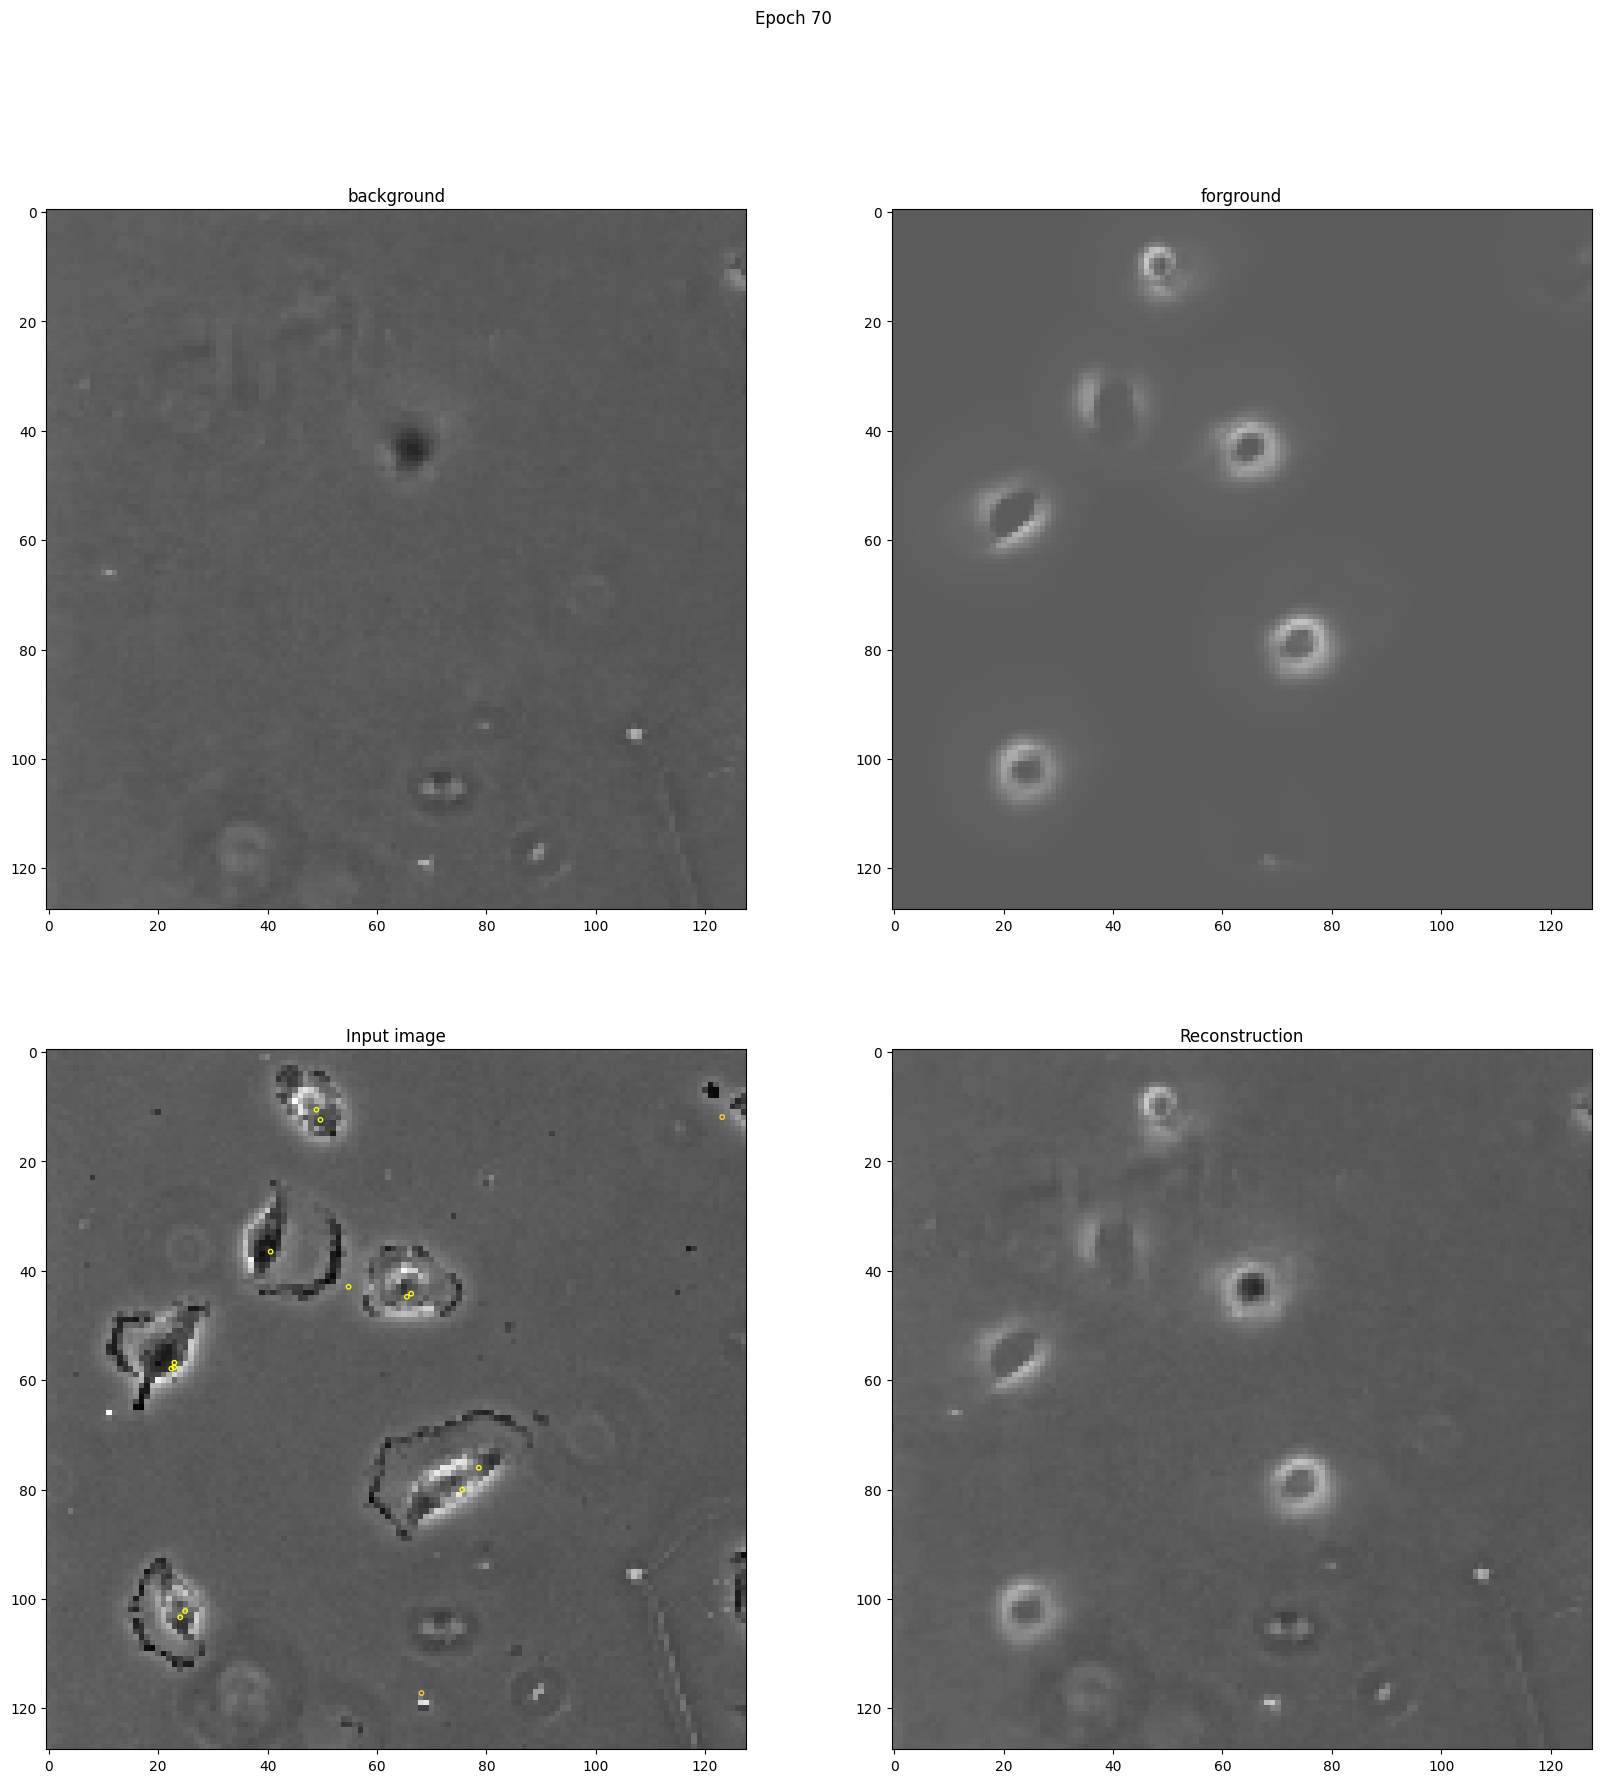

Epoch 72:   2%|▏         | 2/88 [00:00<00:01, 47.59it/s, v_num=2258, loss_step=0.067, recon_loss_step=0.067, kl_loss_step=85.20, kl_for_step=74.30, kl_back_step=10.90, loss_epoch=0.0573, recon_loss_epoch=0.0573, kl_loss_epoch=82.90, kl_for_epoch=72.70, kl_back_epoch=10.20]   

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [20]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

In [79]:
seq = test[0]

tra_list = model.extract_obj_and_tra(seq, 8, presence_floor=0.25, tra_floor=0.11)

print('...........')
plt.imshow(seq[-1][0], cmap='gray')
for i, dict in enumerate(tra_list):
    print(dict)
    plt.plot(dict.get('y'), dict.get('x'), '-o')
plt.show()

IndexError: list index out of range

In [172]:
for i_seq, x in enumerate(training_images):
    x = torch.unsqueeze(x, dim=0)
    x = x.to(model.device)
    (
        recon,
        kl_divergence,
        background_kl,
        xy,
        background,
        x_hat,
        z_pres,
        attention,
        pres_loss,
    ) = model(x)

    x = x.detach().cpu().numpy()
    recon = recon.detach().cpu().numpy()
    pres = z_pres.detach().cpu().numpy()
    xy = xy.detach().cpu().numpy()
    attention = attention.detach().cpu().numpy()

    n = [i for i in range(num_entities)]

    frame = 0
    frame_diff = 1
    print(attention[0, frame*15:(frame+1)*15, (frame+frame_diff)*15:(frame+frame_diff+1)*15])

    print(xy.shape)
        
    break


[[10.749674    5.3619637   0.59110844  2.8823311   3.5231953   1.0154166
   4.7818747   4.665187    1.3265067   2.2564535   0.96901494  1.9234291
   3.8566582   2.6234934   2.5499675 ]
 [15.794519    8.60253     0.2023918   2.7371883   7.7124243   1.6533098
   8.773199    7.3929257   2.84502     4.235193    4.632749    3.747782
   7.052424    6.397347    3.9434671 ]
 [35.14783    16.769012    1.227503    5.871222   14.182765    4.1258607
  22.683334   16.278997    7.058137   12.568348   10.973116    8.437834
  16.402534   15.201575    8.453514  ]
 [ 5.2794046   2.0487103   0.4741726   1.3340994   1.0249684   0.61389345
   3.1740067   2.2571545   0.85003245  1.9151196   0.6989348   0.98534596
   2.0965686   1.5757393   1.1747885 ]
 [10.745296    5.3427815   0.5106793   2.566855    3.8255527   1.0776745
   5.344323    4.7591143   1.5545392   2.653461    1.6551096   2.1134973
   4.1802964   3.1963017   2.5663276 ]
 [15.82708     7.5506225   0.5643779   2.685634    6.342391    1.8500031
  

/workspace/aa-attention/objVAE/objVAE/utils.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

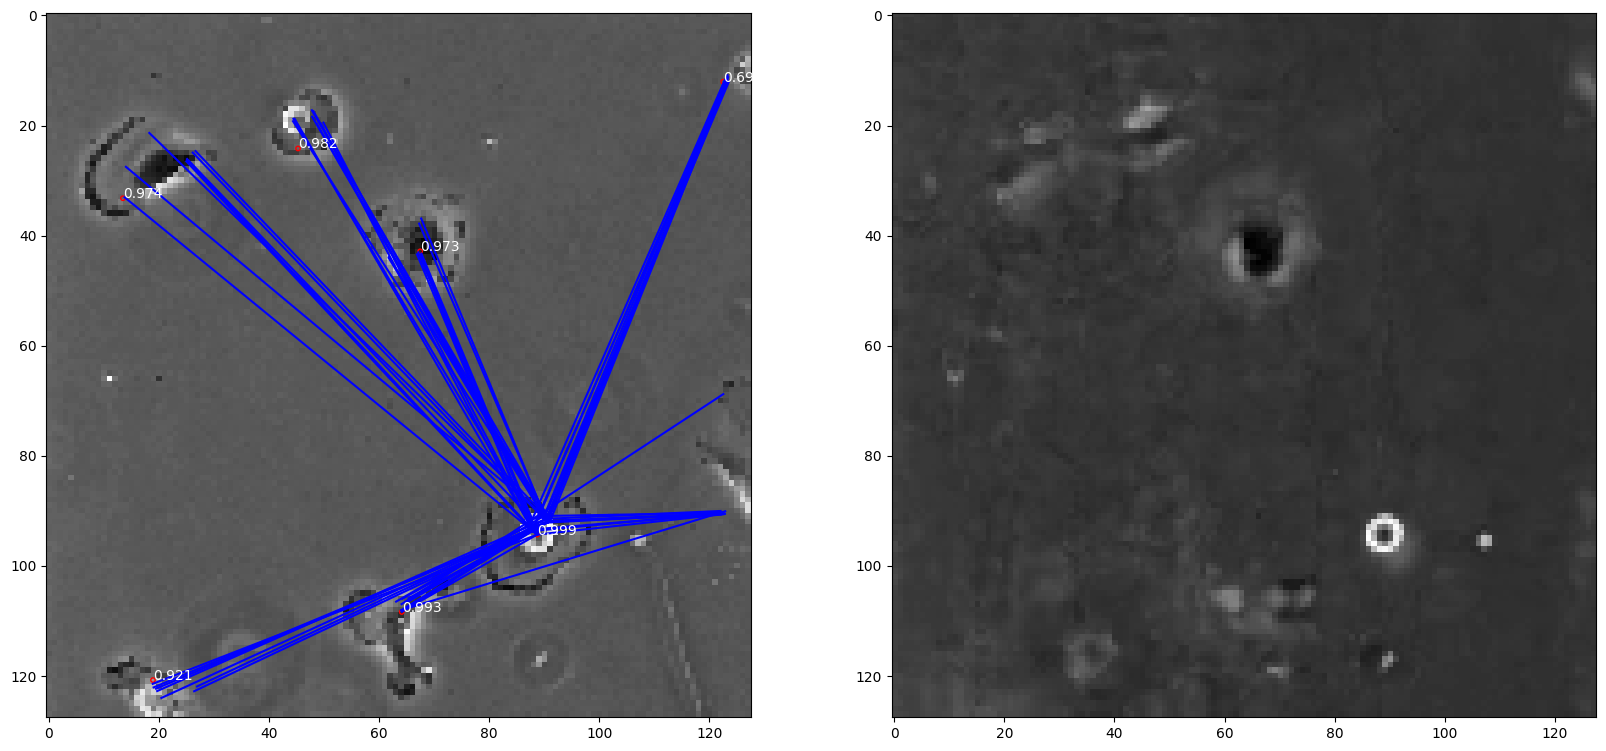

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

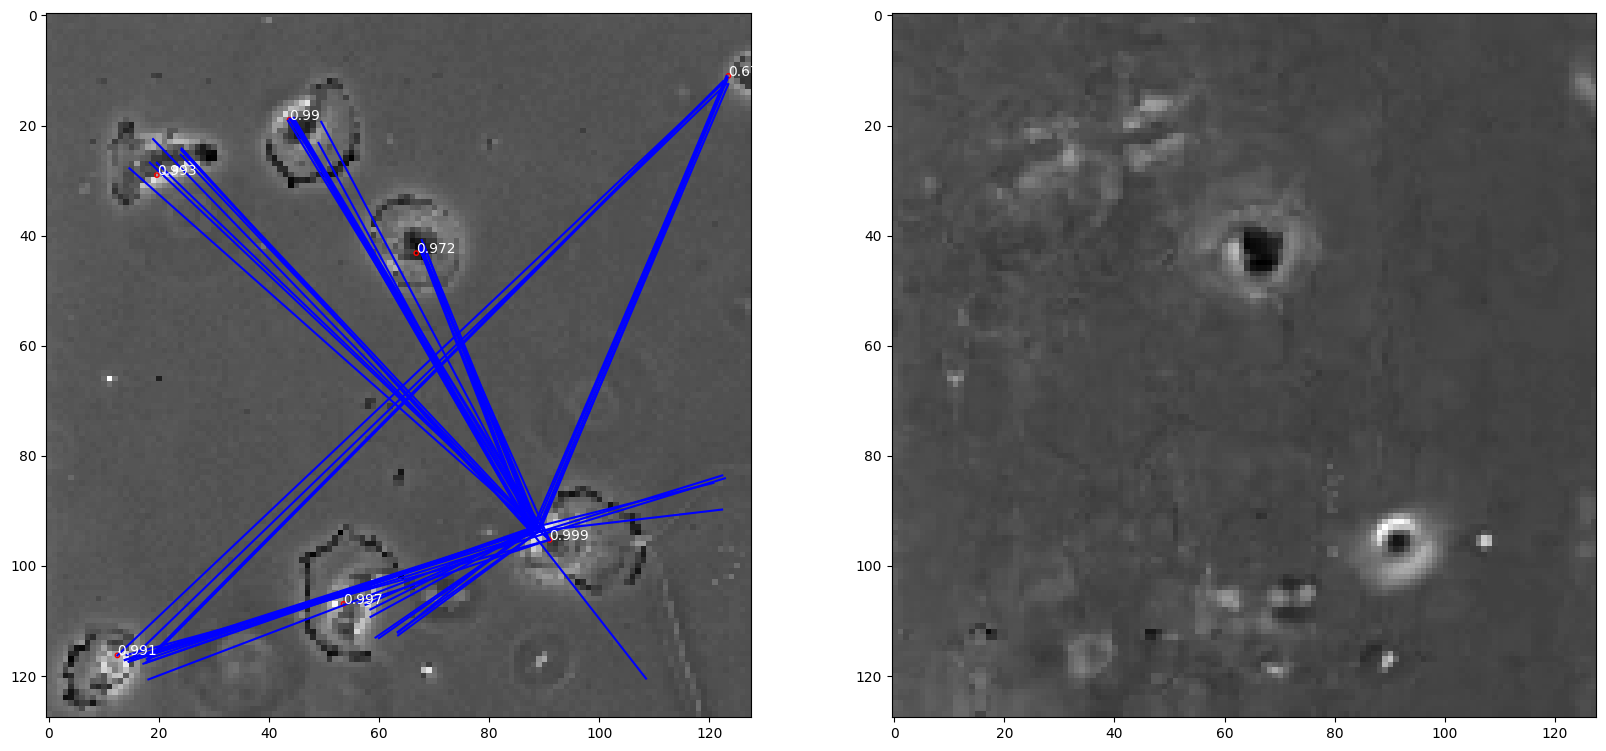

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

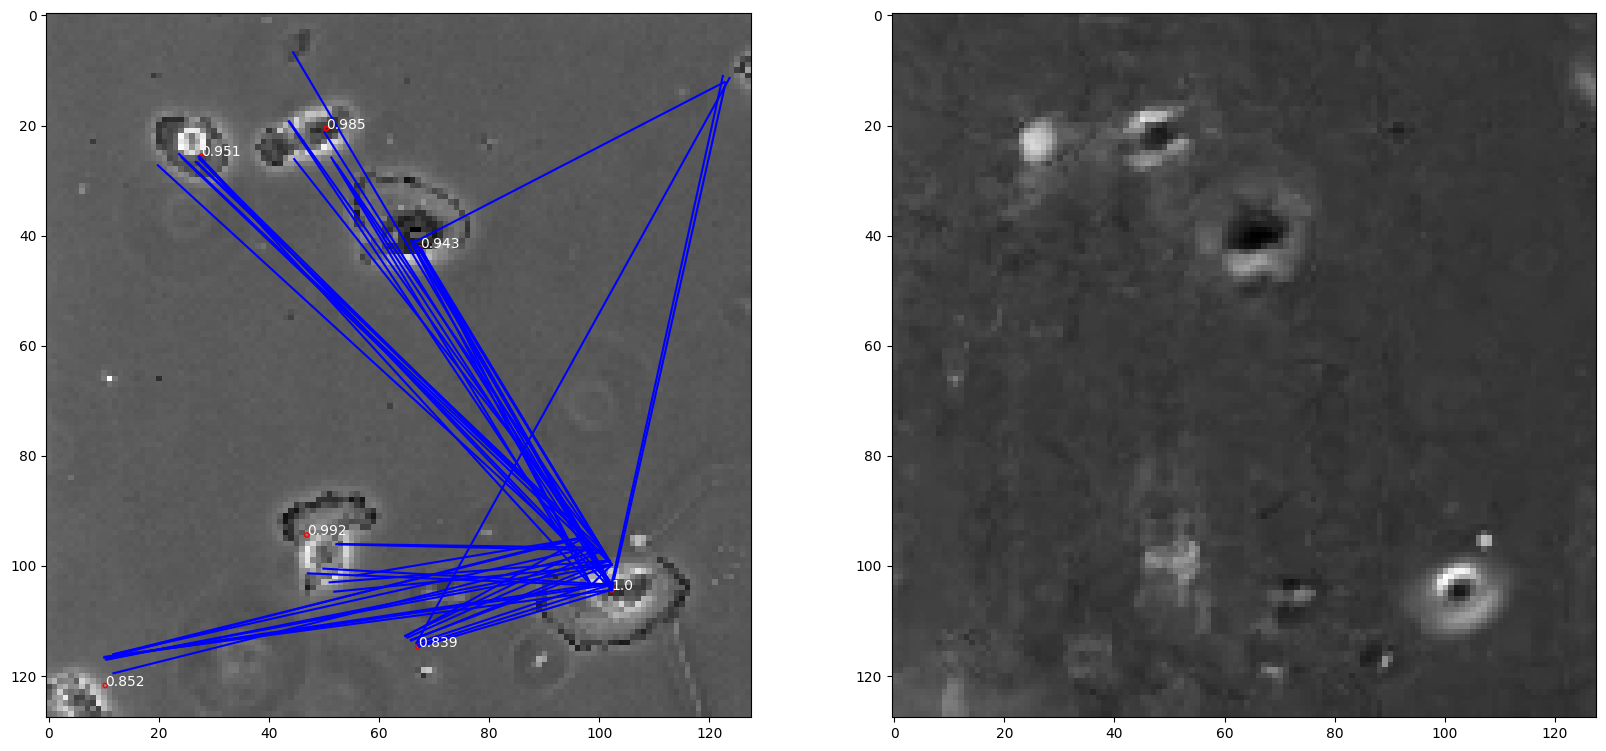

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

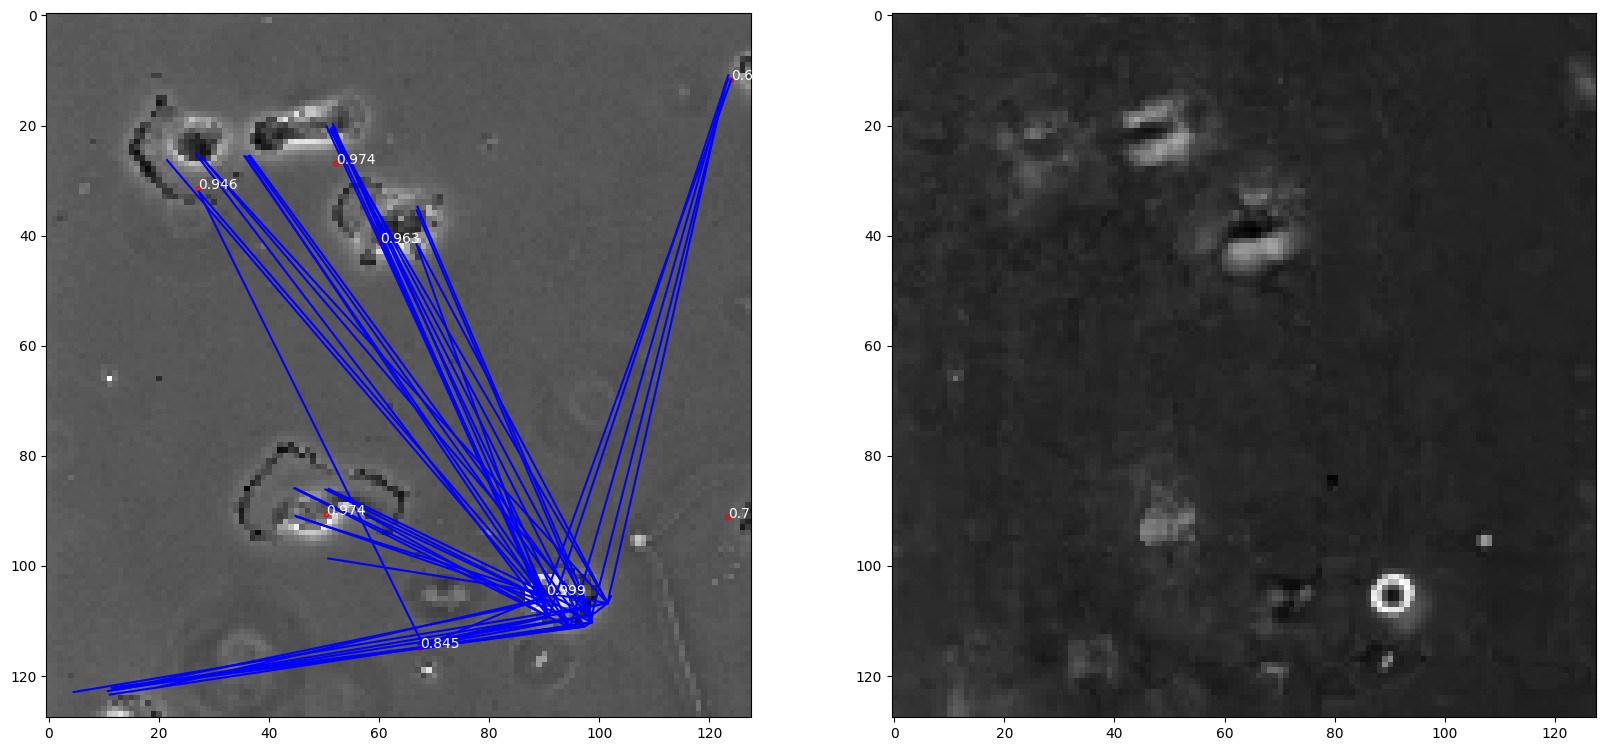

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

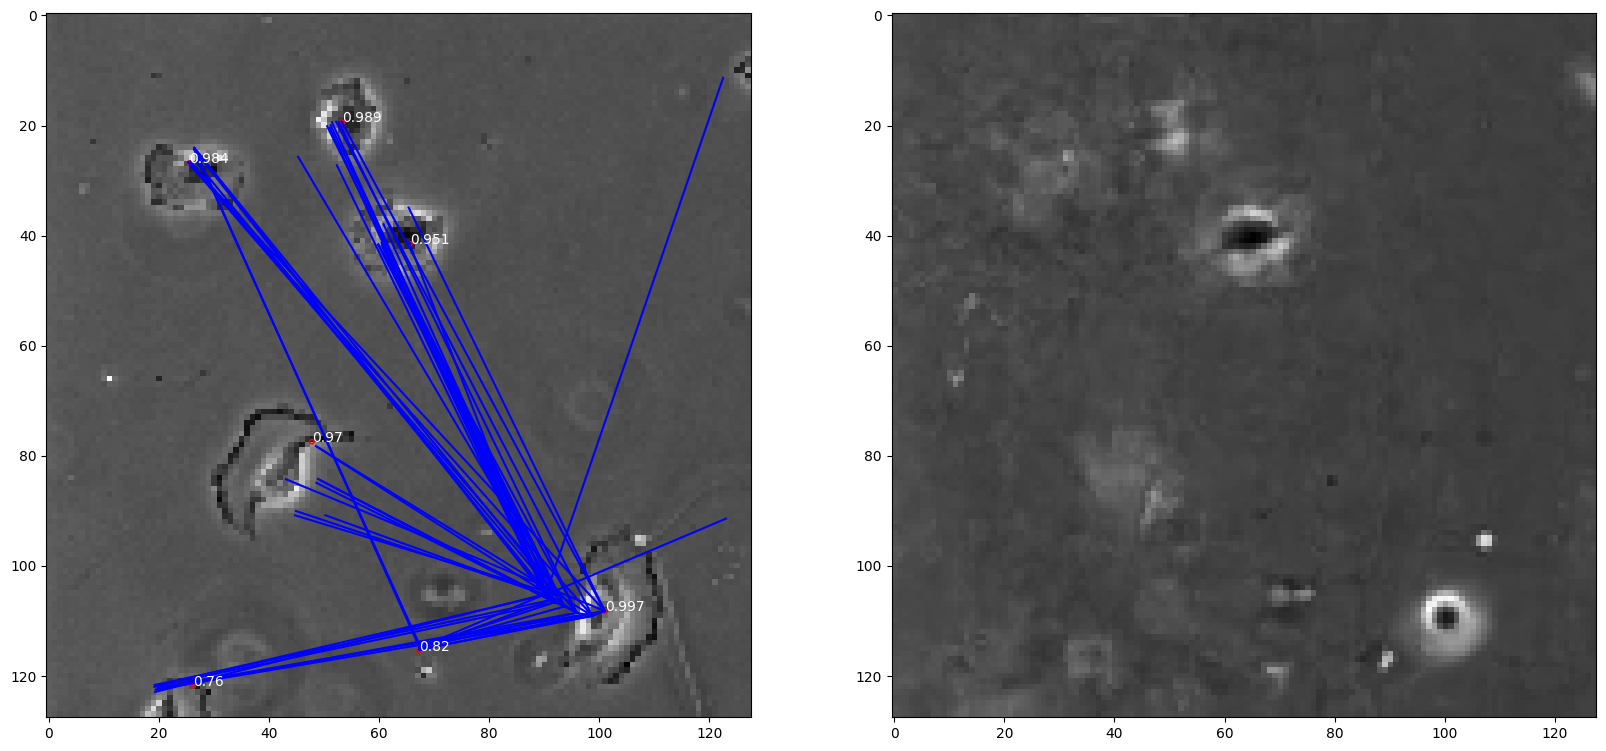

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

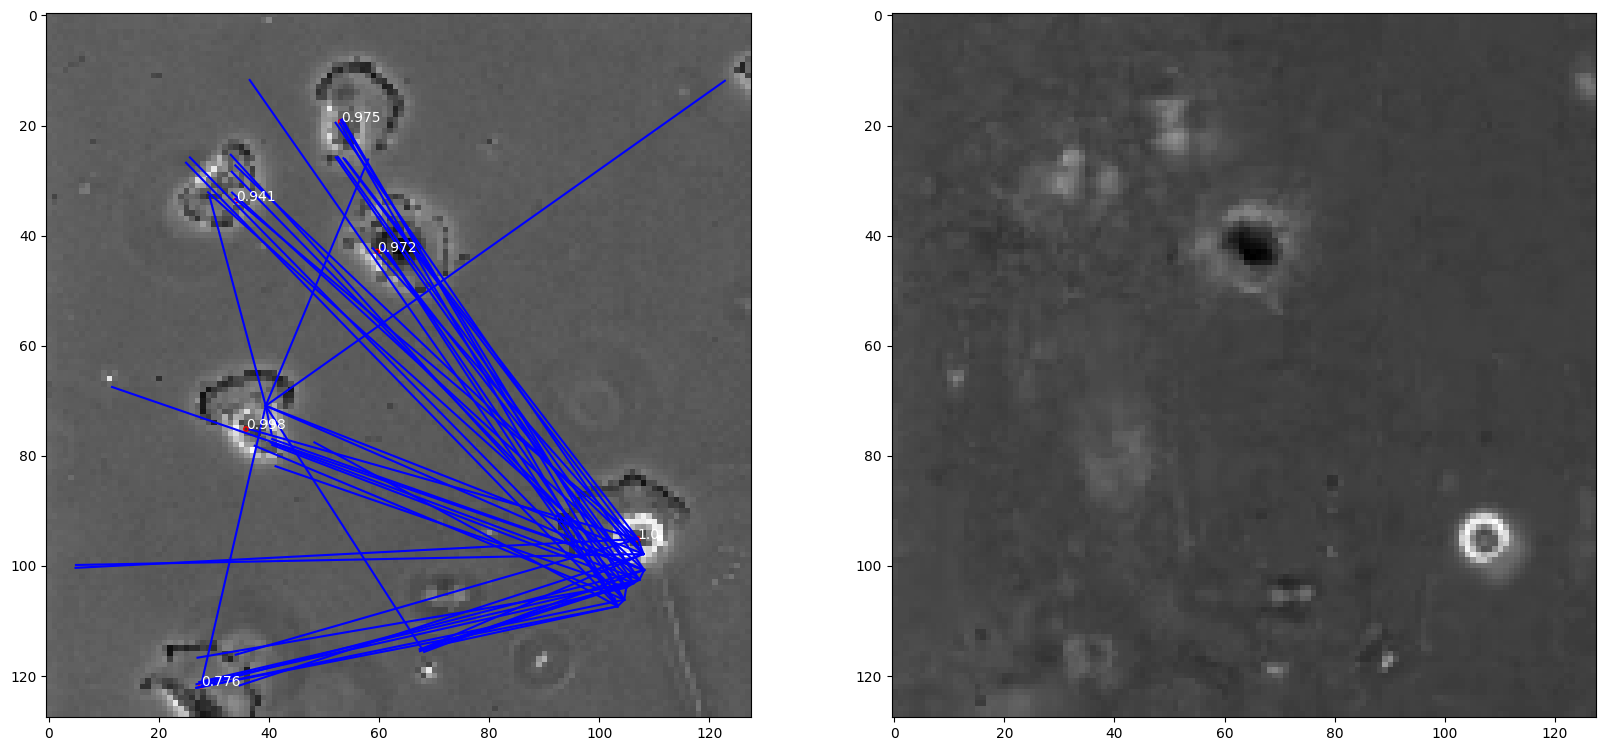

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

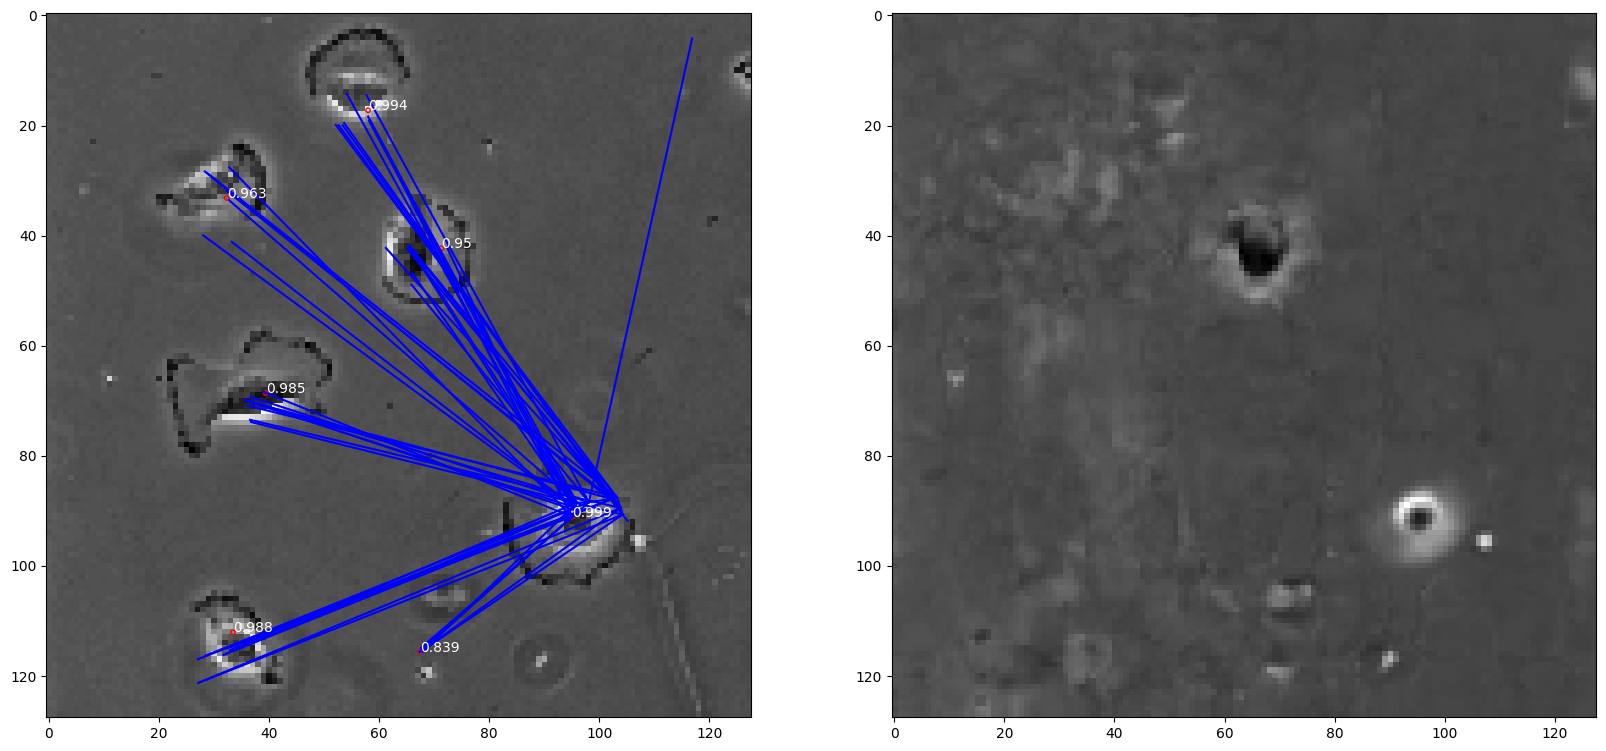

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

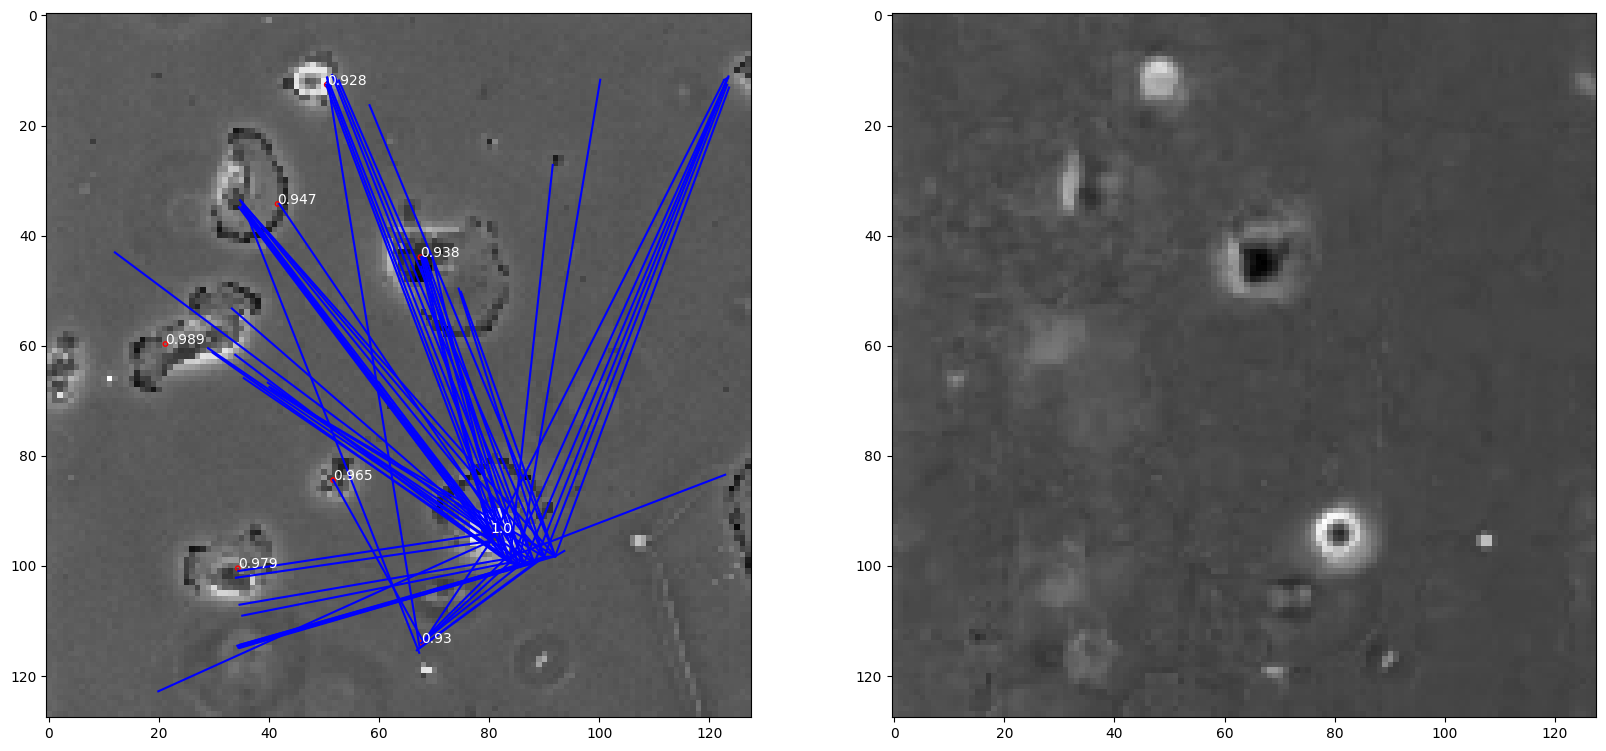

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

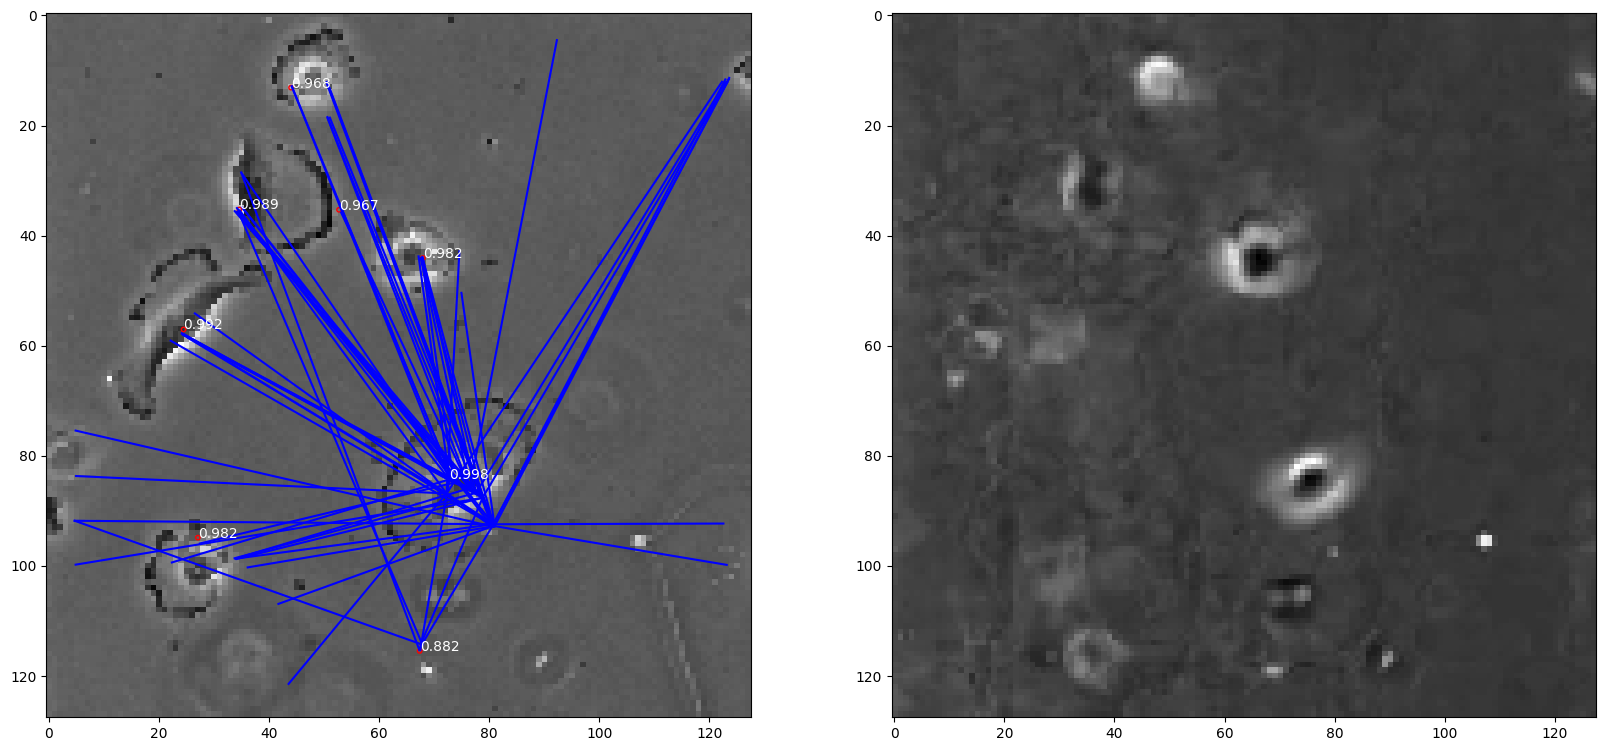

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

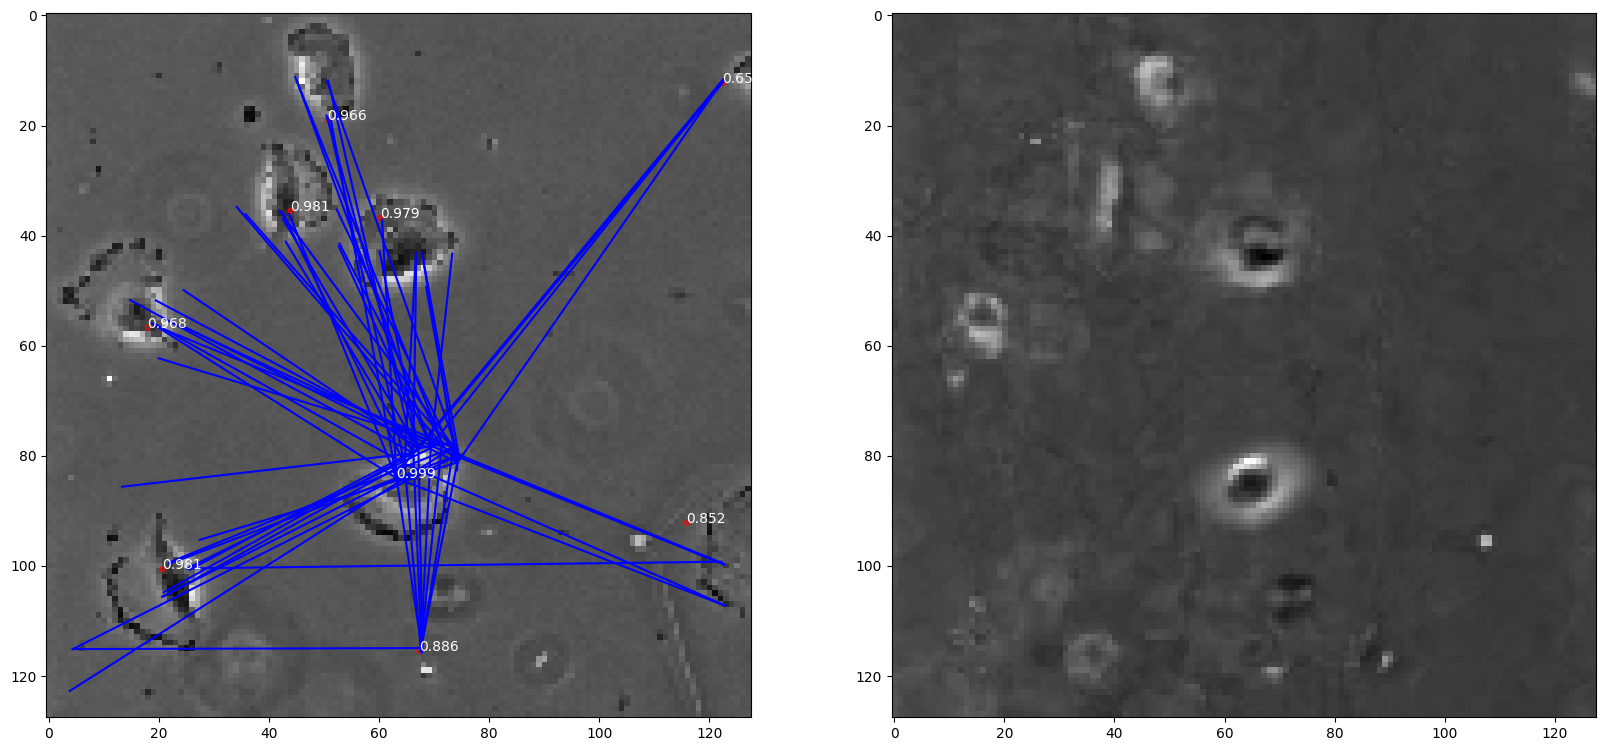

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

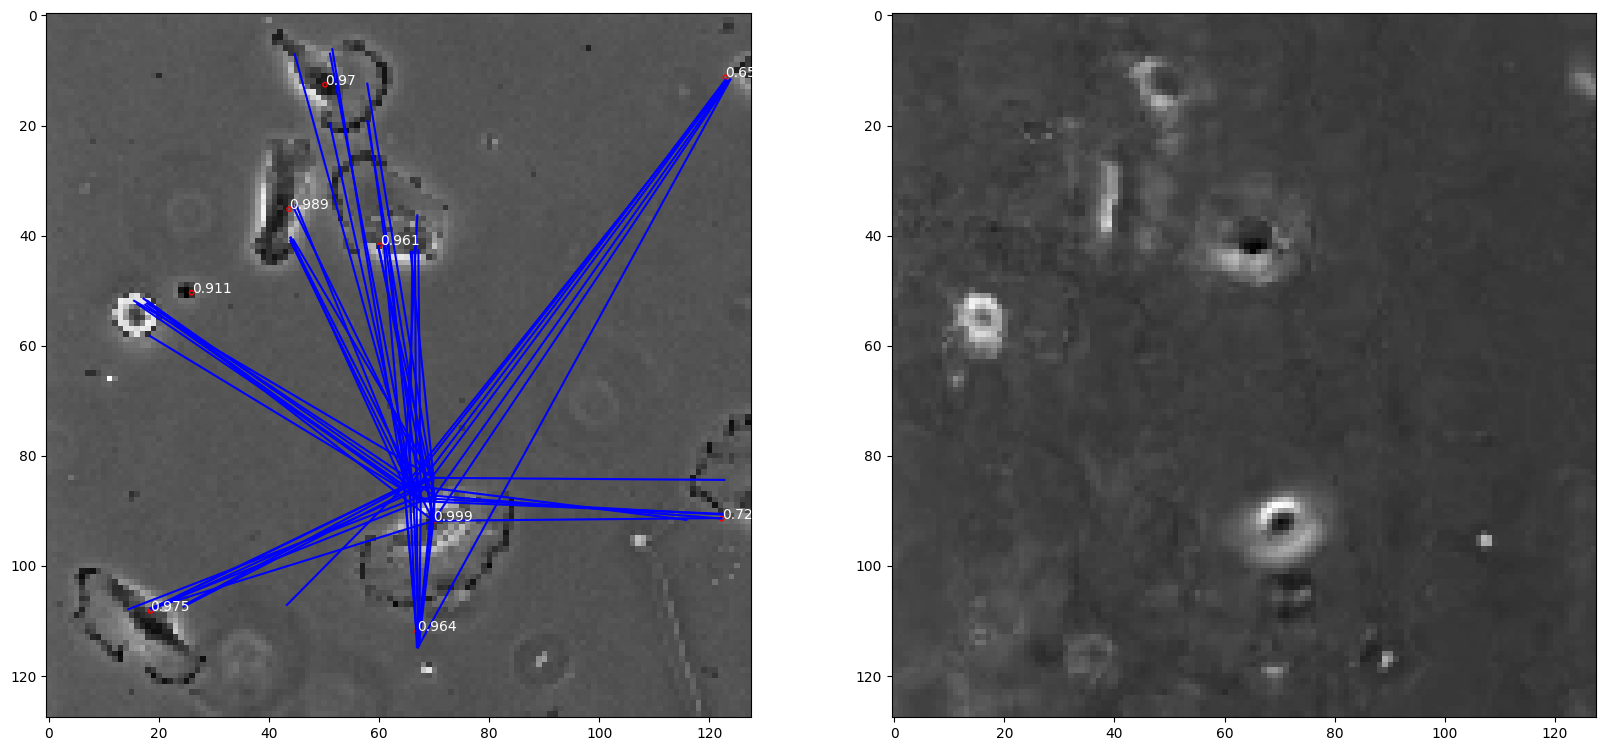

In [173]:
utils.run_test(
    training_images,
    model,
    combine_radius=16,
    plot_num=None,
    num_entities=15,
    pres_floor=0.1,
    tra_floor=0.01
    )

In [76]:
torch.save(model.state_dict(), "../state_dicts/model-U373.pth")